1- Cargar bibliotecas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import os
from bootcampviztools import pinta_distribucion_categoricas, plot_categorical_numerical_relationship, plot_grouped_histograms
from sklearn.model_selection import train_test_split

2- Obtener datos

In [2]:
ruta= "./src/data_sample/ventas/"

archivos_alquiler= list(os.listdir(ruta))
print(archivos_alquiler)
dfs={}

for fichero in archivos_alquiler:
    nombre_df= fichero
    ruta_fichero= ruta+fichero
    df= pd.read_csv(ruta_fichero)
    dfs[fichero]= df
df_total_ventas= pd.concat(dfs.values(), ignore_index=True)

print(len(df_total_ventas))
df_total_ventas

['v_abril_2025.csv', 'v_agosto_2025.csv', 'v_diciembre_2025.csv', 'v_enero_2025.csv', 'v_febrero_2025.csv', 'v_julio_2025.csv', 'v_junio_2025.csv', 'v_marzo_2025.csv', 'v_mayo_2025.csv', 'v_noviembre_2025.csv', 'v_octubre_2025.csv', 'v_septiembre_2025.csv']
24000


,Fuente,Referencia,Operación,Tipología,Título,C.P.,Municipio,Provincia,Distrito,Barrio,...,Descartado,Estado,Ranking,Dormitorios,Baños,Superficie,Precio,Precio unitario,Días,Demanda
0,Fotocasa,0292687,Venta,Plurifamiliar,Piso en Venta en Arrancapins,46007.0,Valencia,Valencia,Extramurs,Arrancapins,...,No,No contactado,9421,4.0,2.0,129,530000,4108,1,Muy baja
1,habitaclia,2629,Venta,Plurifamiliar,Vive la Valencia más auténtica en esta joya e...,NaN,Valencia,Valencia,La Saïdia,Sant Antoni,...,No,No contactado,4728,1.0,1.0,78,250000,3205,1,Muy baja
2,milanuncios,542365647,Venta,Plurifamiliar,Valencia Capital,46009.0,Valencia,Valencia,La Saïdia,Sant Antoni,...,No,No contactado,3671,1.0,1.0,78,250000,3205,1,Muy baja
3,Fotocasa,25VIV06586,Venta,Plurifamiliar,"Piso en Venta en PADRE PEDRO VELASCO, 5, La M...",46011.0,Valencia,Valencia,Poblats Marítims,La Malva-rosa,...,No,No contactado,280,3.0,1.0,64,58500,914,1,Alta
4,habitaclia,25VIV06586,Venta,Plurifamiliar,NaN,NaN,Valencia,Valencia,Poblats Marítims,La Malva-rosa,...,No,No contactado,10154,3.0,1.0,64,58500,914,1,Muy baja
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,habitaclia,64-03483,Venta,Plurifamiliar,Venta piso en Valencia,NaN,Valencia,Valencia,Quatre Carreres,La Punta,...,No,No contactado,345,4.0,1.0,100,165000,1650,3,Alta
23996,milanuncios,557691756,Venta,Plurifamiliar,Valencia Capital,46007.0,Valencia,Valencia,Jesús,La Raïosa,...,No,No contactado,43,3.0,2.0,101,315000,3118,17,Muy alta
23997,milanuncios,557632670,Venta,Plurifamiliar,Barrio del Carmen - Carrer de Pinzón,46003.0,Valencia,Valencia,Ciutat Vella,El Carme,...,No,No contactado,6241,3.0,2.0,87,349900,4021,17,Muy baja
23998,habitaclia,LCV37757-1,Venta,Plurifamiliar,NaN,NaN,Valencia,Valencia,Poblats Marítims,El Grau,...,No,No contactado,5419,3.0,2.0,111,330000,2972,17,Muy baja


In [3]:
df.head()

,Fuente,Referencia,Operación,Tipología,Título,C.P.,Municipio,Provincia,Distrito,Barrio,...,Descartado,Estado,Ranking,Dormitorios,Baños,Superficie,Precio,Precio unitario,Días,Demanda
0,Fotocasa,NaN,Venta,Plurifamiliar,Piso en Venta en Carrer de Sant Joan de la Pe...,46019.0,Valencia,Valencia,Rascanya,Orriols,...,No,No contactado,794,2.0,1.0,70,159000,2271,1,Moderada
1,milanuncios,560093044,Venta,Plurifamiliar,Orriols,46019.0,Valencia,Valencia,Rascanya,Orriols,...,No,No contactado,6555,2.0,1.0,70,159000,2271,1,Muy baja
2,Fotocasa,NaN,Venta,Plurifamiliar,Piso en Venta en Els Orriols,46001.0,Valencia,Valencia,Rascanya,Orriols,...,No,No contactado,6,2.0,1.0,70,159000,2271,1,Muy alta
3,milanuncios,560092256,Venta,Plurifamiliar,Barrio Benicalap - Carrer de Benicadell,46015.0,Valencia,Valencia,Benicalap,Barrio de Benicalap,...,No,No contactado,8070,3.0,1.0,72,180000,2500,1,Muy baja
4,Fotocasa,NaN,Venta,Plurifamiliar,Piso en Venta en Carrer de Sant Joan de la Pe...,46019.0,Valencia,Valencia,Rascanya,Orriols,...,No,No contactado,801,2.0,1.0,70,159000,2271,1,Moderada


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Fuente              2000 non-null   object 
 1   Referencia          1953 non-null   object 
 2   Operación           2000 non-null   object 
 3   Tipología           2000 non-null   object 
 4   Título              1847 non-null   object 
 5   C.P.                1347 non-null   float64
 6   Municipio           2000 non-null   object 
 7   Provincia           2000 non-null   object 
 8   Distrito            2000 non-null   object 
 9   Barrio              1857 non-null   object 
 10  Latitud             2000 non-null   float64
 11  Longitud            2000 non-null   float64
 12  Planta              1673 non-null   object 
 13  Anunciante          2000 non-null   object 
 14  Empresa             1961 non-null   object 
 15  Aire acondicionado  2000 non-null   object 
 16  Ascens

In [5]:
# nulos
# print(df.isnull().sum()/len(df)*100)
# creando el indice de referencia
df["Referencia_interna"]= df["Latitud"].astype(str).replace(".","")+ df["Longitud"].astype(str).replace(".","")
df["Referencia_interna"]

0              39.4954428-0.369104
1       39.4940903323-0.3710177677
2       39.4942298986-0.3708782014
3             39.4908707-0.3943799
4              39.4954428-0.369104
                   ...            
1995    39.4468009423-0.3370047397
1996    39.4543412456-0.3901562521
1997          39.4774322-0.3824911
1998    39.4584919581-0.3339615419
1999          39.4955381-0.3703577
Name: Referencia_interna, Length: 2000, dtype: object

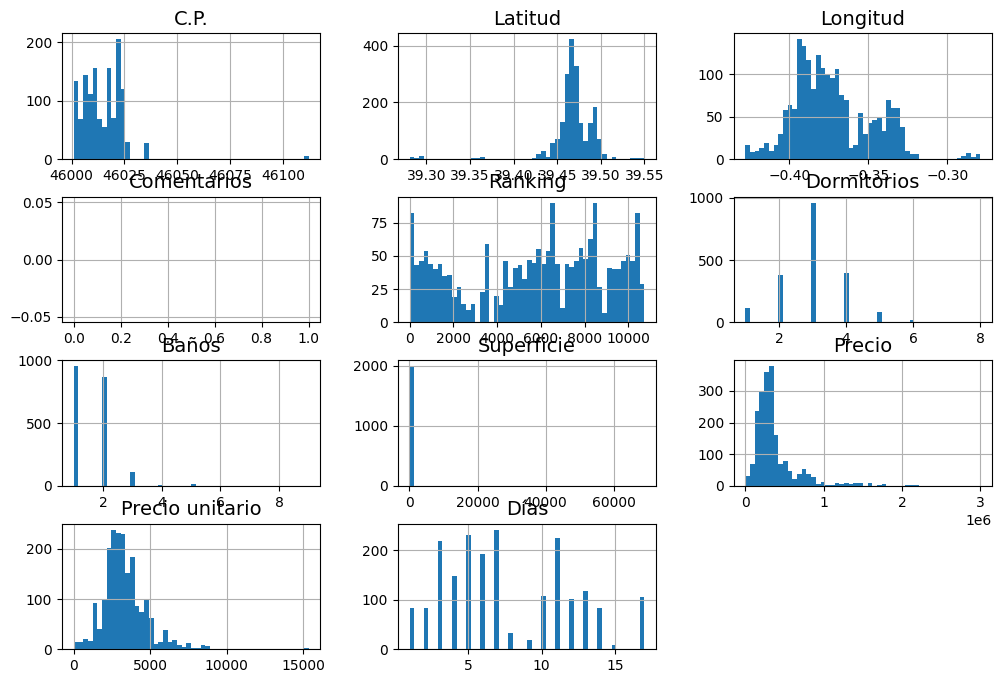

In [6]:
# Código extra para los tamaños de las fuentes y los "ticks" de los ejes, esto no lo vimos al hablar de matplotlib así que una extra
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(12, 8)) # La forma de generar histogramas de una sola vez para las variables numéricas de un dataset
plt.show()

3- Separar Train y test

In [7]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [8]:
len(train_set)

1600

In [9]:
len(test_set)

400

4 - Proceso de "EDA"

In [10]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1600 entries, 968 to 1126
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Fuente              1600 non-null   object 
 1   Referencia          1565 non-null   object 
 2   Operación           1600 non-null   object 
 3   Tipología           1600 non-null   object 
 4   Título              1473 non-null   object 
 5   C.P.                1068 non-null   float64
 6   Municipio           1600 non-null   object 
 7   Provincia           1600 non-null   object 
 8   Distrito            1600 non-null   object 
 9   Barrio              1486 non-null   object 
 10  Latitud             1600 non-null   float64
 11  Longitud            1600 non-null   float64
 12  Planta              1336 non-null   object 
 13  Anunciante          1600 non-null   object 
 14  Empresa             1568 non-null   object 
 15  Aire acondicionado  1600 non-null   object 
 16  Ascensor 

In [11]:
# Eliminar duplicados
train_set = train_set.sort_values(by='Precio')
train_set = df.drop_duplicates(subset=['Referencia_interna', 'Operación'])

train_set["Referencia_interna"].nunique()
train_set.nunique()
len(train_set)
train_set

,Fuente,Referencia,Operación,Tipología,Título,C.P.,Municipio,Provincia,Distrito,Barrio,...,Estado,Ranking,Dormitorios,Baños,Superficie,Precio,Precio unitario,Días,Demanda,Referencia_interna
0,Fotocasa,NaN,Venta,Plurifamiliar,Piso en Venta en Carrer de Sant Joan de la Pe...,46019.0,Valencia,Valencia,Rascanya,Orriols,...,No contactado,794,2.0,1.0,70,159000,2271,1,Moderada,39.4954428-0.369104
1,milanuncios,560093044,Venta,Plurifamiliar,Orriols,46019.0,Valencia,Valencia,Rascanya,Orriols,...,No contactado,6555,2.0,1.0,70,159000,2271,1,Muy baja,39.4940903323-0.3710177677
2,Fotocasa,NaN,Venta,Plurifamiliar,Piso en Venta en Els Orriols,46001.0,Valencia,Valencia,Rascanya,Orriols,...,No contactado,6,2.0,1.0,70,159000,2271,1,Muy alta,39.4942298986-0.3708782014
3,milanuncios,560092256,Venta,Plurifamiliar,Barrio Benicalap - Carrer de Benicadell,46015.0,Valencia,Valencia,Benicalap,Barrio de Benicalap,...,No contactado,8070,3.0,1.0,72,180000,2500,1,Muy baja,39.4908707-0.3943799
6,Fotocasa,NaN,Venta,Plurifamiliar,Piso en Venta en Barrio de Benicalap,46001.0,Valencia,Valencia,Benicalap,Barrio de Benicalap,...,No contactado,6630,3.0,1.0,72,180000,2500,1,Muy baja,39.4894415986-0.3958090014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,habitaclia,64-03483,Venta,Plurifamiliar,Venta piso en Valencia,NaN,Valencia,Valencia,Quatre Carreres,La Punta,...,No contactado,345,4.0,1.0,100,165000,1650,3,Alta,39.4468009423-0.3370047397
1996,milanuncios,557691756,Venta,Plurifamiliar,Valencia Capital,46007.0,Valencia,Valencia,Jesús,La Raïosa,...,No contactado,43,3.0,2.0,101,315000,3118,17,Muy alta,39.4543412456-0.3901562521
1997,milanuncios,557632670,Venta,Plurifamiliar,Barrio del Carmen - Carrer de Pinzón,46003.0,Valencia,Valencia,Ciutat Vella,El Carme,...,No contactado,6241,3.0,2.0,87,349900,4021,17,Muy baja,39.4774322-0.3824911
1998,habitaclia,LCV37757-1,Venta,Plurifamiliar,NaN,NaN,Valencia,Valencia,Poblats Marítims,El Grau,...,No contactado,5419,3.0,2.0,111,330000,2972,17,Muy baja,39.4584919581-0.3339615419


In [13]:
# Columnas a eliminar: Tipologia, Titulo, provincia , municipio, C.P, planta, Empresa, imagen, URL, Teléfono, email, posible agencia, comentarios, descartado, Estado, Ranking, Dias
columnas_a_eliminar=[
    "Tipología", "Título", "Provincia", "Municipio", "C.P.", 
    "Planta", "Empresa", "Imagen", "URL", "Teléfono", 
    "Email", "Posible agencia", "Referencia", "Operación", "Latitud", "Longitud", "Fecha de creación", "Comentarios", "Descartado","Estado", "Ranking", "Días",
]

train_set = train_set.drop(columns=columnas_a_eliminar)

print(f"Columnas restantes: {len(train_set.columns)}")
train_set.head()

Columnas restantes: 20


,Fuente,Distrito,Barrio,Anunciante,Aire acondicionado,Ascensor,Garaje,Trastero,Terraza,Piscina,Zonas verdes,Zona deportiva,Conservación,Dormitorios,Baños,Superficie,Precio,Precio unitario,Demanda,Referencia_interna
0,Fotocasa,Rascanya,Orriols,Particular,No,Sí,No,No,No,No,No,No,Bueno,2.0,1.0,70,159000,2271,Moderada,39.4954428-0.369104
1,milanuncios,Rascanya,Orriols,Particular,No,No,No,No,No,No,No,No,NaN,2.0,1.0,70,159000,2271,Muy baja,39.4940903323-0.3710177677
2,Fotocasa,Rascanya,Orriols,Particular,No,No,No,No,No,No,No,No,NaN,2.0,1.0,70,159000,2271,Muy alta,39.4942298986-0.3708782014
3,milanuncios,Benicalap,Barrio de Benicalap,Particular,No,Sí,No,No,No,No,No,No,NaN,3.0,1.0,72,180000,2500,Muy baja,39.4908707-0.3943799
6,Fotocasa,Benicalap,Barrio de Benicalap,Particular,No,Sí,No,No,No,No,No,No,NaN,3.0,1.0,72,180000,2500,Muy baja,39.4894415986-0.3958090014
